In [1]:
import os
import time
import traceback
import numpy as np
import pandas as pd
from dataloader import TrimodalLoader
from model import TrimodalModel
import torch


## Process
1. Load all data
2. Sub or oversample so that all dataset samples align
3. Form inputs of shape [mod1_x, mod2_x, mod3_x], [y]
4. Train embracenet

In [2]:
def load_iris():
    """Loads iris features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../iris/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"iris_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels
        

In [3]:
def load_fingerprint():
    """Loads fingerprint features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../fingerprint/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"fp_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [4]:
def load_face():
    """Loads face features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../face/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"face_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [5]:
if len(os.listdir("feats")) == 0:
    emb_iris, lab_iris = load_iris()
    emb_fp, lab_fp = load_fingerprint()
    emb_face, lab_face = load_face()
else:
    emb_iris = pd.read_csv("feats/iris.csv")
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

In [6]:
if len(os.listdir("feats")) == 0:

    print(len(lab_iris), len(lab_fp), len(lab_face))
    emb_iris["label"] = lab_iris
    emb_fp["label"] = lab_fp
    emb_face["label"] = lab_face

    emb_iris.to_csv("feats/iris.csv", index=False)
    emb_fp.to_csv("feats/fingerprint.csv", index=False)
    emb_face.to_csv("feats/face.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris.csv")    
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

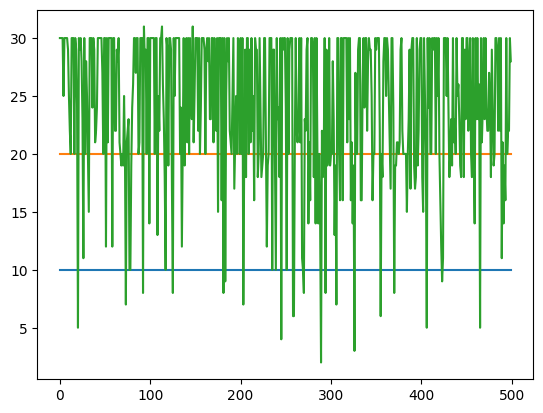

In [7]:
import matplotlib.pyplot as plt
plt.plot(emb_iris["label"].value_counts().sort_index())
plt.plot(emb_fp["label"].value_counts().sort_index())
plt.plot(emb_face["label"].value_counts().sort_index()) 

In [8]:
def get_fusion(df1, df2, df3):
    """
    Concatenates three dataframes into a single dataframe with pairs of embeddings and labels.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames containing embeddings and labels.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame with balanced pairs of embeddings and labels.
    """
    final_df1 = pd.DataFrame()
    final_df2 = pd.DataFrame()
    final_df3 = pd.DataFrame()
    
    
    # Iterate over unique labels
    for label in df1['label'].unique():
        # Filter each DataFrame for the current label
        sub_df1 = df1[df1['label'] == label]
        sub_df2 = df2[df2['label'] == label]
        sub_df3 = df3[df3['label'] == label]
        
        # Determine the maximum number of samples across the three DataFrames
        num_samples = max(len(sub_df1), len(sub_df2), len(sub_df3))
        
        # Oversample each subset to match the maximum sample size
        sub_df1 = sub_df1.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df2 = sub_df2.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df3 = sub_df3.sample(num_samples, replace=True).reset_index(drop=True)
        
        final_df1 = pd.concat([final_df1, sub_df1], axis=0)
        final_df2 = pd.concat([final_df2, sub_df2], axis=0)
        final_df3 = pd.concat([final_df3, sub_df3], axis=0)
        
    
    return final_df1, final_df2, final_df3


In [9]:
def remap_labels(emb_iris, emb_face, emb_fp):
    mapping = {val: idx for idx, val in enumerate(emb_iris["label"].unique())}
    
    emb_iris["label"] = emb_iris["label"].map(mapping)
    emb_face["label"] = emb_face["label"].map(mapping)
    emb_fp["label"] = emb_fp["label"].map(mapping)
    
    return emb_iris, emb_face, emb_fp

In [10]:
if "iris_sampled.csv" not in os.listdir("feats"):
    emb_iris, emb_face, emb_fp = get_fusion(emb_iris, emb_face, emb_fp)
    
    emb_iris, emb_face, emb_fp = remap_labels(emb_iris, emb_face, emb_fp)
    
    emb_iris.to_csv("feats/iris_sampled.csv", index=False)
    emb_fp.to_csv("feats/fingerprint_sampled.csv", index=False)
    emb_face.to_csv("feats/face_sampled.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris_sampled.csv")
    emb_fp = pd.read_csv("feats/fingerprint_sampled.csv")
    emb_face = pd.read_csv("feats/face_sampled.csv")

In [11]:
len(emb_iris), len(emb_face), len(emb_fp)

(12603, 12603, 12603)

In [12]:
# Prepare dataloader
train_subjects_uniq = len(emb_iris["label"].unique()) // 5
train_subjects = emb_iris["label"].unique()[:train_subjects_uniq]
test_subjects = emb_iris["label"].unique()[train_subjects_uniq:]

iris_train = emb_iris[emb_iris["label"].isin(train_subjects)]
fp_train = emb_fp[emb_fp["label"].isin(train_subjects)]
face_train = emb_face[emb_face["label"].isin(train_subjects)]


iris_test = emb_iris[emb_iris["label"].isin(test_subjects)]
fp_test = emb_fp[emb_fp["label"].isin(test_subjects)]
face_test = emb_face[emb_face["label"].isin(test_subjects)]


iris_train_x, iris_train_y = iris_train.drop("label", axis=1), iris_train["label"]
fp_train_x, fp_train_y = fp_train.drop("label", axis=1), fp_train["label"]
face_train_x, face_train_y = face_train.drop("label", axis=1), face_train["label"]


iris_test_x, iris_test_y = iris_test.drop("label", axis=1), iris_test["label"]
fp_test_x, fp_test_y = fp_test.drop("label", axis=1), fp_test["label"]
face_test_x, face_test_y = face_test.drop("label", axis=1), face_test["label"]

In [13]:
iris_train = iris_train.drop(columns="label")

In [14]:
list(iris_train_y)[:10], list(fp_train_y)[:10], list(face_train_y)[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
len(iris_train_y), len(fp_train_y), len(face_train_y)

(2638, 2638, 2638)

In [16]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

True

In [17]:
list(iris_test_y) == list(fp_test_y) == list(face_test_y)

True

In [18]:
# We only need one set of labels
y = iris_train_y

In [19]:
dataloader = TrimodalLoader(
    torch.tensor(iris_train_x.values, dtype=torch.float32), 
    torch.tensor(fp_train_x.values, dtype=torch.float32), 
    torch.tensor(face_train_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

test_loader = TrimodalLoader(
    torch.tensor(iris_test_x.values, dtype=torch.float32), 
    torch.tensor(fp_test_x.values, dtype=torch.float32), 
    torch.tensor(face_test_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

In [20]:
iris_train_y

0      0
1      0
2      0
3      0
4      0
      ..
24    99
25    99
26    99
27    99
28    99
Name: label, Length: 2638, dtype: int64

In [21]:
iris_train.iloc[0].shape

(1408,)

In [22]:
# initialize
batch_size = 32
device = "cpu"
train_path = "tmp/train/"
max_steps = 100
log_freq = 2
summary_freq = 5
save_freq = 5
sleep_ratio = 0
restore_path = None
global_step = 0
os.environ["CUDA_VISIBLE_DEVICES"] = device
os.makedirs(train_path, exist_ok=True)

In [23]:
# Prepare model
model = TrimodalModel()
input_size_list = [iris_train.iloc[0].shape[0], fp_train_x.iloc[0].shape[0], face_train_x.iloc[0].shape[0]]
print(input_size_list)

print(input_size_list)
n_classes = iris_train_y.nunique()
print("N classes: ", n_classes)
model.prepare(is_training=True, input_size_list=input_size_list, global_step=global_step, n_classes=n_classes)

[1408, 1408, 512]
[1408, 1408, 512]
N classes:  100
Created docking_0 with input size 1408 and output size 256
Parameter containing:
tensor([[ 0.0127, -0.0172,  0.0038,  ...,  0.0195, -0.0023, -0.0054],
        [ 0.0015, -0.0150, -0.0242,  ..., -0.0090, -0.0196, -0.0211],
        [ 0.0204,  0.0256,  0.0140,  ...,  0.0106,  0.0137, -0.0070],
        ...,
        [-0.0012, -0.0057, -0.0026,  ..., -0.0138,  0.0250,  0.0148],
        [ 0.0191,  0.0124, -0.0153,  ...,  0.0072,  0.0232,  0.0230],
        [-0.0007, -0.0239,  0.0049,  ..., -0.0045, -0.0118,  0.0160]],
       requires_grad=True)
Created docking_1 with input size 1408 and output size 256
Parameter containing:
tensor([[-0.0103,  0.0128, -0.0072,  ...,  0.0095, -0.0246, -0.0146],
        [-0.0058, -0.0088,  0.0211,  ...,  0.0077, -0.0063,  0.0106],
        [ 0.0111, -0.0249, -0.0199,  ..., -0.0236, -0.0032, -0.0049],
        ...,
        [-0.0170, -0.0254, -0.0143,  ..., -0.0241,  0.0160,  0.0132],
        [-0.0030,  0.0065,  0.02

In [24]:
# model > restore
if restore_path is not None:
    model.restore(ckpt_path=restore_path)
    print("restored the model")

# model > summary
summary_path = os.path.join(train_path, "summary")

In [25]:
iris_train.iloc[0].shape, fp_train_x.iloc[0].shape, face_train_x.iloc[0].shape

((1408,), (1408,), (512,))

In [26]:
print("begin training")
local_train_step = 0
losses = []
while model.global_step < max_steps:
    global_train_step = model.global_step + 1
    local_train_step += 1

    start_time = time.time()


    input_list, truth_list = dataloader.get_batch(
        batch_size=batch_size
    )  # [mod1, mod2, ...], label
    truth_list = torch.as_tensor(
        [int(label) for label in truth_list],  # Convert NumPy scalar arrays to Python integers
        dtype=torch.long,
        device=device)
    
    print(truth_list)
    loss = model.train_step(
        input_list=input_list, truth_list=truth_list
    )
    losses.append(loss)
    print(loss)
    duration = time.time() - start_time

    if local_train_step % log_freq == 0:
        print(
            "step %d, loss %.6f (%.3f sec/batch)"
            % (global_train_step, loss, duration)
        )

    if local_train_step % save_freq == 0:
        model.save(base_path=train_path)
        print("saved a model checkpoint at step %d" % (global_train_step))

# except KeyboardInterrupt:
#     print("interrupted (KeyboardInterrupt)")
# except Exception as e:
#     print(traceback.format_exc())

# finalize
print("finished")


begin training
tensor([76, 50, 58, 14,  9, 37, 23, 22, 49, 52, 71, 19, 38, 98,  7, 86, 27, 85,
        71, 16, 92, 70,  9, 27,  4, 34, 19, 25, 26, 18, 67, 34])
tensor(4.5923, grad_fn=<NllLossBackward0>)
4.59234094619751
tensor([ 3,  3, 40, 62, 60, 54, 46, 72, 73, 42, 78, 69, 89, 75, 75, 61,  6, 90,
        17, 77,  0, 88,  8, 90, 41, 23, 29, 29, 82,  8, 14, 75])
tensor(4.7289, grad_fn=<NllLossBackward0>)
4.7289137840271
step 2, loss 4.728914 (0.014 sec/batch)
tensor([28, 47, 83, 61, 26, 49, 48, 68, 11, 65,  0, 29, 41, 37, 88, 52, 18, 31,
        28, 31, 68, 85, 55, 69, 99, 69, 50, 43, 75, 91, 64, 58])
tensor(4.5261, grad_fn=<NllLossBackward0>)
4.5261383056640625
tensor([29, 16, 32,  7, 98,  9,  6,  7, 69, 64, 12, 84, 69, 71, 84, 50, 63, 45,
        30, 53, 29, 41, 29, 93, 63,  2, 16, 85,  4, 12, 41, 82])
tensor(4.4114, grad_fn=<NllLossBackward0>)
4.411376953125
step 4, loss 4.411377 (0.010 sec/batch)
tensor([10, 76, 60, 71, 61, 52, 87, 13, 12,  6, 97, 31, 93, 99, 36, 34,  3, 32,
      

In [27]:
45056 / 256

176.0

In [28]:
torch.cuda.is_available()

False

In [29]:
input_size_list

[1408, 1408, 512]

In [30]:
512 * 32

16384

Text(0.5, 1.0, 'EmbraceNet Loss')

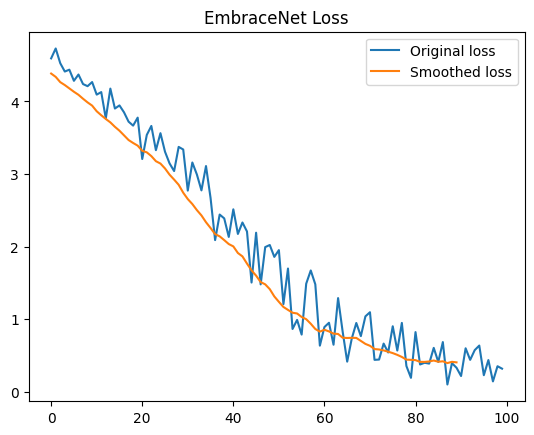

In [31]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

sigma = 5
kernel_size = 11  # Choose an odd number
kernel = gaussian_kernel(kernel_size, sigma)
smoothed_vector = np.convolve(losses, kernel, mode='same')

plt.plot(losses, label="Original loss")
plt.plot(smoothed_vector[5:-5], label="Smoothed loss")
plt.legend()
plt.title("EmbraceNet Loss")
